In [1]:
#importing all the module which is used in this project
import pandas as pd
import numpy as np
import torch #this library we used to do tensor based calculation
import sklearn
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

In [2]:
#now loading the data
data = pd.read_csv('kaggle_diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [3]:
#selecting input and output variable
x = data.drop('Outcome',axis=1)
y = data['Outcome']

In [4]:
#if i want  to check the shape and type of input and output variable
x.shape,x.ndim,y.shape,y.ndim

((2000, 8), 2, (2000,), 1)

In [5]:
#checking the output variable are balanced or imbalanced
data.Outcome.value_counts()

Outcome
0    1316
1     684
Name: count, dtype: int64

In [6]:
#splitting the data into 80:20 ratio
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [7]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1600, 8), (400, 8), (1600,), (400,))

In [8]:
#to show input variables dtype
x_train.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

In [9]:
#now doing scaling to input variable so that at the time of training model..model will not do biasing between features
#so that all the feature will have same variance range in it (finally if we check all the feature std will be 1 mean will be 0
# and distribution will be normal)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

x_train = ss.fit_transform(x_train) #changing them into 2d numpy array object
x_test = ss.transform(x_test)


In [10]:
x_train.shape,x_train.ndim,x_train.dtype,x_test.shape,x_test.ndim,x_test.dtype

((1600, 8), 2, dtype('float64'), (400, 8), 2, dtype('float64'))

In [11]:
type(y_train)

pandas.core.series.Series

In [12]:
#now changing the y_train,y_test pandas object to 1d numpy array object
y_train_np = np.array(y_train,dtype=np.float32)
y_test_np = np.array(y_test,dtype=np.float32)

In [13]:
y_train_np.shape,y_train_np.ndim,type(y_train_np),y_train_np.dtype

((1600,), 1, numpy.ndarray, dtype('float32'))

# now changing all the numpy array train and testing set to tensor object

In [14]:
x_train_tensor = torch.from_numpy(x_train).float()
x_test_tensor = torch.from_numpy(x_test).float()
y_train_tensor = torch.from_numpy(y_train_np).float()
y_test_tensor = torch.from_numpy(y_test_np).float()

In [15]:
x_train_tensor.dtype,x_test_tensor.dtype,y_train_tensor.dtype,y_test_tensor.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

# now creating custom dataset class so that training and testing data will get converted into batches

In [16]:
#in this custom class we gonna used 3 special or magical methods 
class CustomDataset(Dataset): 
    #creating __init__ method to initialize instance variable 
    def __init__(self,input,output):
        #inheriting all the property from parent class
        super().__init__()
        self.input = input
        self.output = output
        
    #this magical method we used to return the totalnumber of records present in inputs object
    def __len__(self):
        return len(self.input)
    
    #below magical method we used to return randomly selected batch record corresponding to that label also
    def __getitem__(self, index):
        return self.input[index],self.output[index] 
        
    
        

In [17]:
#creating an object of custom Dataset class
train_dataset = CustomDataset(x_train_tensor,y_train_tensor)
test_dataset = CustomDataset(x_test_tensor,y_test_tensor)

In [18]:
#using dataloader class to create batch size of data corresponding to labels
#creating an object dataloader class

train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True,pin_memory=True)
test_dataloader = DataLoader(test_dataset,batch_size=8,shuffle=True,pin_memory=True)


In [19]:
for feature,label in train_dataloader:
    print(feature)
    print(label)
    break

tensor([[ 1.0337, -0.2254, -0.1867, -1.3029, -0.7217,  0.0710, -0.6690,  0.7373],
        [-0.2010, -0.3195,  1.0869, -0.5493, -0.0186, -0.4729,  0.0812, -0.3541],
        [-0.5097, -0.0373,  0.3440,  1.0205,  0.2248,  0.9240, -0.8051, -0.3541],
        [ 0.7250,  0.1195,  0.4501,  0.6438, -0.7217, -0.5718,  0.3028,  1.3250],
        [-0.8184, -0.5704,  0.5562, -0.6121,  0.0175, -1.5854,  0.0686, -0.9418],
        [ 0.1077, -0.5704, -0.5051,  0.7694,  1.0091, -1.0168,  1.5722, -0.0183],
        [ 1.0337,  0.6526,  1.0869,  0.2042,  3.6052, -0.2256, -1.0805,  0.8213],
        [-0.2010,  0.2136,  0.1317,  0.2670,  0.9910,  0.0216,  0.2522, -0.5220]])
tensor([1., 0., 0., 1., 0., 0., 1., 1.])


In [20]:
x.shape

(2000, 8)

# now initializing or defining the ANN 

In [21]:
#we gonna used sequential container layer to intact the neurals layers init
from torch.nn import Sequential


#creating custom class to initalise the neural network in it..
class MyNeuralNetwork(nn.Module):
    #using constructor class to define the neural layers or instance variable init 
    def __init__(self,input_size):
        #inheriting all the parent class constructor property
        super().__init__()
        
        self.model = Sequential(
            #hidden layer
            nn.Linear(input_size,6),
            nn.ReLU(),
            
            #2nd hidden layer
            nn.Linear(6,4),
            nn.ReLU(),
            
            #output layer
            nn.Linear(4,1),
            nn.Sigmoid()
            
        )
        
    #now creating another method to perform forward propogation algorithm
    def forward(self,x):
        return self.model(x)

In [22]:
torch.cuda.is_available()

True

In [23]:
#now using gpu power in my model to train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
#now creating an object of Custom neural network class
model = MyNeuralNetwork(input_size=x_train_tensor.shape[1]).to(device=device)
model

MyNeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [25]:
#if i want to see how many trainable parameter need to be trained by this model
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MyNeuralNetwork                          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       54
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       28
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       5
│    └─Sigmoid: 2-6                      --
Total params: 87
Trainable params: 87
Non-trainable params: 0

In [26]:
#now defining loss function and optimizer
#loss function will calculate loss value based on pblm statement we r working onit
#optimizer will update trainable parameter in each layer

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss = torch.nn.BCELoss()

In [27]:
epochs = 30 #total 30 iteration we r giving this to model

In [28]:
for train_batch_feature,train_batch_label in train_dataloader:
    print(train_batch_feature.shape)
    print(train_batch_feature.ndim)
    print(train_batch_label.shape)
    print(train_batch_label.ndim)
    
    break

torch.Size([8, 8])
2
torch.Size([8])
1


# Training steps we have to follow

In [29]:
#iterating the loop
for epoch in range(epochs):
    #getting the batch_size training data and passing them to define neural network model
    for train_batch_feature,train_batch_label in train_dataloader:
        train_batch_feature = train_batch_feature.to(device)
        train_batch_label = train_batch_label.to(device)
        
        #first algorithm that work is forward pass and we are getting prediction
        y_pred = model.forward(train_batch_feature)
        
        #calculating loss value
        losses = loss(y_pred.squeeze(),train_batch_label)
        
        #before applying backpropogation to the loss value first we have to clear the gradient inside optimizers
        optimizer.zero_grad()
        
        #doing backpropogation to calculate gradients in each layer of trainable parameter
        losses.backward()
        
        #updating wts and bias in each layer
        optimizer.step()


# now evaluating the model and checking the performance of model

In [30]:
#defining variables 
#using total_samples_count and total_correct_predicting_model se we are getting accuracy of model
total_samples_count = 0 #initializing zero initially
total_correct_predicting_model_count = 0


#now defining the list to store actual output and predicted output in it.
all_actual_output = []
all_predicted_output = []

#now starting the evaluation of model
model.eval()

#now iterating testing dataloader samples and dont track the gradient init.
with torch.no_grad():
    for test_batch_feature,test_batch_label in test_dataloader:
        test_batch_feature = test_batch_feature.to(device)
        test_batch_label = test_batch_label.to(device)
        
        #now passing test feature batch to neural network architecture and rtn we r getting predicted_output probability!!
        y_pred = model.forward(test_batch_feature)
        
        #test_loss_value
        test_loss_value = loss(y_pred.squeeze(),test_batch_label)
        
        #changing predicted_output probability to binary class float() method we used to get 
        prediction = (y_pred.squeeze()>=0.5).float() 
        
        #now checking in each batch mei how many are correct prediction comapre with actual output
        total_correct_pred_per_batch = (prediction==test_batch_label).sum().item()
        total_sample_in_each_batch = test_batch_label.shape[0]
        #print(f"num_correct_prediction_in_each_batch : {total_correct_pred_per_batch}, num_samples_in_each_batch: {total_sample_in_each_batch}")
        
        #now updating counts variable
        total_correct_predicting_model_count = total_correct_predicting_model_count+total_correct_pred_per_batch
        total_samples_count = total_samples_count+total_sample_in_each_batch
        
        
        #now appending or extending the lst objects
        all_actual_output.extend(test_batch_label.cpu().numpy())
        all_predicted_output.extend(prediction.cpu().numpy())
        
        
# Calculate accuracy
accuracy = total_correct_predicting_model_count / total_samples_count
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")



✅ Test Accuracy: 78.75%


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(all_actual_output, all_predicted_output))
print(classification_report(all_actual_output, all_predicted_output))

[[229  34]
 [ 51  86]]
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       263
         1.0       0.72      0.63      0.67       137

    accuracy                           0.79       400
   macro avg       0.77      0.75      0.76       400
weighted avg       0.78      0.79      0.78       400



In [33]:
training_losses = []
test_losses = []

for epoch in range(epochs):
    # ------- Training Phase -------
    model.train()
    training_running_loss = 0.0
    
    for train_batch_feature, train_batch_label in train_dataloader:
        train_batch_feature = train_batch_feature.to(device)
        train_batch_label = train_batch_label.to(device)

        # Forward pass
        y_pred = model(train_batch_feature)
        losses = loss(y_pred.squeeze(), train_batch_label)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        training_running_loss += losses.item()
    
    avg_train_loss = training_running_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)

    # ------- Testing Phase -------
    model.eval()
    test_running_loss = 0.0
    total_samples_count = 0
    total_correct_predicting_model_count = 0

    with torch.no_grad():
        for test_batch_feature, test_batch_label in test_dataloader:
            test_batch_feature = test_batch_feature.to(device)
            test_batch_label = test_batch_label.to(device)

            y_pred = model(test_batch_feature)
            test_loss_value = loss(y_pred.squeeze(), test_batch_label)
            test_running_loss += test_loss_value.item()

            prediction = (y_pred.squeeze() >= 0.5).float()
            total_correct_predicting_model_count += (prediction == test_batch_label).sum().item()
            total_samples_count += test_batch_label.size(0)

    avg_test_loss = test_running_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)

    accuracy = total_correct_predicting_model_count / total_samples_count

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, "
          f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch [1/30], Train Loss: 0.4328, Test Loss: 0.4346, Test Accuracy: 79.50%
Epoch [2/30], Train Loss: 0.4314, Test Loss: 0.4322, Test Accuracy: 78.50%
Epoch [3/30], Train Loss: 0.4307, Test Loss: 0.4337, Test Accuracy: 78.75%
Epoch [4/30], Train Loss: 0.4297, Test Loss: 0.4320, Test Accuracy: 79.00%
Epoch [5/30], Train Loss: 0.4291, Test Loss: 0.4325, Test Accuracy: 79.25%
Epoch [6/30], Train Loss: 0.4279, Test Loss: 0.4336, Test Accuracy: 78.75%
Epoch [7/30], Train Loss: 0.4271, Test Loss: 0.4308, Test Accuracy: 79.00%
Epoch [8/30], Train Loss: 0.4261, Test Loss: 0.4326, Test Accuracy: 78.50%
Epoch [9/30], Train Loss: 0.4250, Test Loss: 0.4324, Test Accuracy: 78.75%
Epoch [10/30], Train Loss: 0.4245, Test Loss: 0.4326, Test Accuracy: 79.50%
Epoch [11/30], Train Loss: 0.4238, Test Loss: 0.4305, Test Accuracy: 79.25%
Epoch [12/30], Train Loss: 0.4230, Test Loss: 0.4299, Test Accuracy: 79.00%
Epoch [13/30], Train Loss: 0.4230, Test Loss: 0.4338, Test Accuracy: 79.25%
Epoch [14/30], Train 

In [34]:
import matplotlib.pyplot as plt

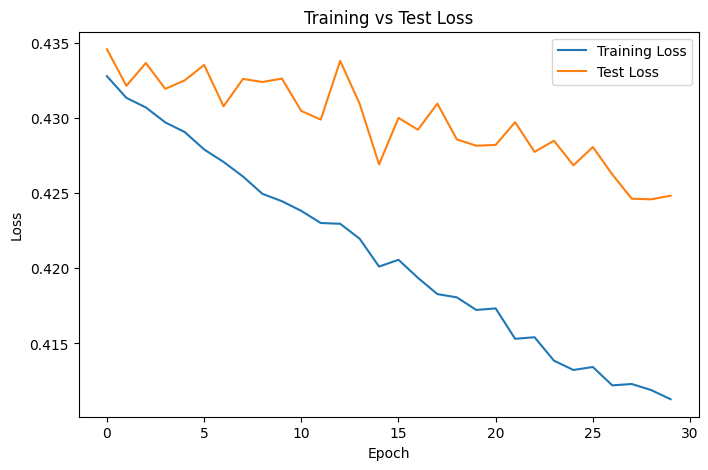

In [35]:
plt.figure(figsize=(8,5))
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.show()

In [ ]:
test_losses

[0.4479107603430748]